## Setup relevant module imports ##

For some reason, on the standard udacity-carnd ami, the opencv and moviepy installs end up on a different path than what the sys.path property is expecting. Hence i had to augment that property.

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.5/dist-packages')

import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time

from moviepy.editor import VideoFileClip,concatenate_videoclips
from IPython.display import HTML
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

%matplotlib inline

## Data exploration ##

### Extract and summarise raw image data ###

In [2]:
def getRawImages(basedir):
    image_types = os.listdir(basedir)
    resultArray = []
    for imtype in image_types:
        resultArray.extend(glob.glob(basedir+'/'+imtype+'/*'))
    return resultArray    

cars = getRawImages('vehicles')
print('Number of vehicles images found', len(cars))
notcars = getRawImages('non-vehicles')
print('Number of non-vehicles images found', len(notcars))

Number of vehicles images found 8792
Number of non-vehicles images found 8968


## Research appropriate hyperparameters ##

### Research  HOG and bin tuning hyper parameters ###

In [3]:
# play with these values to see how your classifier
# performs under different  scenarios
xy_overlap = (0.5, 0.5)
xy_window = [64,64]
y_start_stop = [340, 680] # Min and max in y to search in slide_window()
x_start_stop = [760, 1260]
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
vis = True

### Setup convenience functions for HOG and bin processing ###

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=spatial_size):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=hist_bins, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0],
                        channel3_hist[0]))
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block), 
                      transform_sqrt=True, 
                      visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                     hog_channel=hog_channel,spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                    xy_window=xy_window, xy_overlap=xy_overlap):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

### Extract Car and non-car features from raw images ###
Extract features using raw images and the parameters set earlier

In [5]:
print('Parameters in use:','orientations:',orient,', pixels_per_cell:',pix_per_cell,
     ', cells_per_block:',cell_per_block,', color_space:',color_space)
print('starting car features extraction. ETA < 40 seconds. Standby ...')
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('finished car features extraction. Seconds to complete extraction..',round(time.time()-t, 2))
print('starting not-car features extraction. ETA < 40 seconds. Standby ...')
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('finished not-car features extration. Seconds to complete extracttion...',round(time.time()-t, 2))

Parameters in use: orientations: 9 , pixels_per_cell: 8 , cells_per_block: 2 , color_space: YCrCb
starting car features extraction. ETA < 40 seconds. Standby ...
finished car features extraction. Seconds to complete extraction.. 43.73
starting not-car features extraction. ETA < 40 seconds. Standby ...
finished not-car features extration. Seconds to complete extracttion... 43.68


### Train the dataset ###
Preprocess the features, do a train/test split on the data, run a LinearSVC on the training data and finally store the classifer in a pickle.

In [6]:
# Begin feature pre-processing
print('Starting preprocessing of features.')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler normalize
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split training features into train/test
print('starting train/test aplit ..\nusing:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block and ',color_space,
    'color space')
# print('starting train/test aplit ..')
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('finishied train/test aplit ..')

# Use a linear SVC 
print('Starting classification using SVC. ETA < 30 seconds. Standby ...')
# Check the training time for the SVC
t=time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
print('finishing classification using SVC. Seconds to train SVC...',round(time.time()-t, 2))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

#  save data in pickle
print('saving classifier data in pickle')
with open("classifier.pickle", "wb") as f:
    pickle.dump((svc, X_scaler ), f)

Starting preprocessing of features.
starting train/test aplit ..
using: 9 orientations 8 pixels per cell and 2 cells per block and  YCrCb color space
finishied train/test aplit ..
Starting classification using SVC. ETA < 30 seconds. Standby ...
finishing classification using SVC. Seconds to train SVC... 18.59
Test Accuracy of SVC =  0.9896
saving classifier data in pickle


In [7]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space= color_space,
                    spatial_size=spatial_size, hist_bins=hist_bins,
                    hist_range=(0, 256), orient=orient,
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Starting single image transformation using SVC
Seconds to transform a single sample image using SVC:  1.66


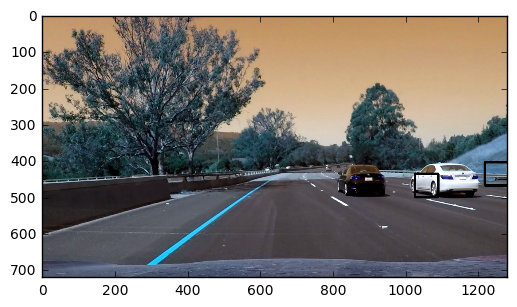

In [8]:
# Check the transform time for a single sample
print('Starting single image transformation using SVC')
t=time.time()
image = cv2.imread('test_images/test6.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(64, 64), xy_overlap=xy_overlap)
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                    spatial_size=spatial_size, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                    hist_feat=hist_feat, hog_feat=hog_feat)
window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)
print('Seconds to transform a single sample image using SVC: ',round(time.time()-t, 2))
plt.imshow(window_img)